# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [1]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [2]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

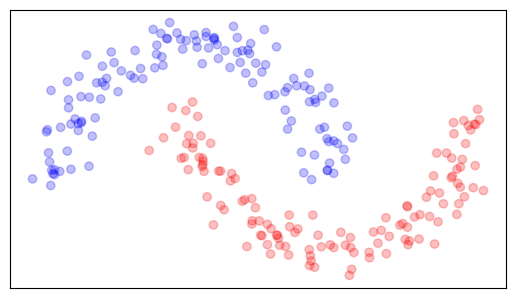

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)

plot_decision_surface(X,y)

In [4]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

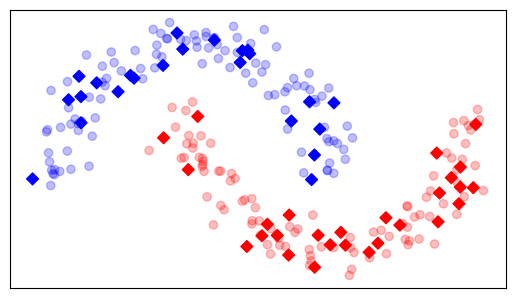

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test)

| Shape         | Class | Data Type | Color  |
|---------------|-------|-----------|--------|
| Circle        | 0     | Train     | Blue   |
| Diamond       | 0     | Test      | Blue   |
| Circle        | 1     | Train     | Red    |
| Diamond       | 1     | Test      | Red    |


In [6]:
# LEAVE BLANK

In [7]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_train_pred = logistic.predict(X_train)
y_test_pred = logistic.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.85
Testing Accuracy: 0.90


In [9]:
# LEAVE BLANK

In [10]:
# LEAVE BLANK

In [11]:
# LEAVE BLANK

In [12]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

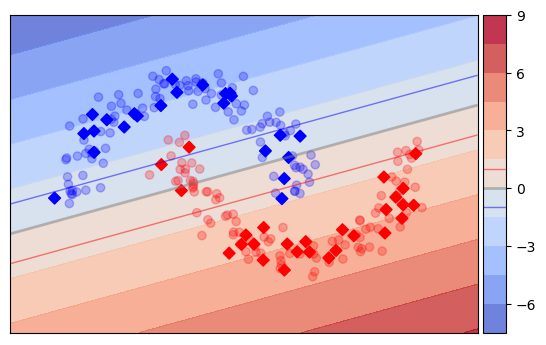

In [13]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

1. What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?

The logistic regression model's decision boundary is a linear line that tries to separate the two moon-shaped classes.
Given the complex structure of the make_moons dataset, a linear boundary like this one results in substantial misclassification, especially in the curved regions where both classes intertwine.

Issues with Model Performance

- Visual Issues: The decision boundary visually cuts through the clusters without following the curved distribution. This shows that many data points close to the boundary are incorrectly classified.
- Overlapping Points: In the area where the two classes meet, particularly in the top and bottom curves, the boundary cuts directly through the middle, leading to significant misclassification of the blue and red classes.
- Performance Metrics: From the plot, it is clear that the logistic regression model is not able to fit the data properly because it is unable to model non-linear relationships. 

2. Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?

The decision boundary struggles most in the areas where the curves of both classes overlap.
The accuracy metric alone does not tell the full story, as it ignores the areas where one class is heavily misclassified over the other. Precision and recall metrics would reveal these discrepancies more effectively. 
From the plot, you can see that many data points close to the linear boundary are in fact not classified correctly. Therefore, additional metrics, such as precision, recall, and F1-score, are required to properly evaluate how well the model handles the overlapping regions.

3. Do you think logistic regression is an appropriate model for this dataset? Why or why not?

The visualization confirms that logistic regression is not appropriate for this dataset due to its inability to learn complex, non-linear patterns. A linear decision boundary fails to capture the curved structure of the data effectively.
In comparison, models such as SVM with RBF kernel or k-NN can adapt to non-linear structures and would create more appropriate decision boundaries for this dataset. For example, SVM with an RBF kernel would form a flexible decision surface that could more accurately follow the shape of the two moons.

4. Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

The visualization supports the conclusion that the model is underfitting the data.
The linear decision boundary is too simple to capture the underlying relationship between features, leading to high bias and limited flexibility.
Both training and testing performance are similarly moderate, which indicates that the model has high bias rather than high variance—a common sign of underfitting.

<b>Suggested Improvements<b>
- Use Non-linear Models: To improve the decision boundary, using a model capable of non-linear decision surfaces would significantly help. For instance, an SVM with an RBF kernel, Decision Tree, or Neural Network could learn the data's structure much better.
- Visualizing Improved Boundaries:
A next step could be to fit an SVM with an RBF kernel and visualize the new decision boundary. This would help illustrate how a non-linear model improves classification.

<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# fit a decision tree classifier to the training data
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# compute the accuracy, precision, and recall for the training sets
y_train_pred = dt.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# compute the accuracy, precision, and recall for the testing sets
y_test_pred = dt.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

print(f"Training Precision: {train_precision}")
print(f"Testing Precision: {test_precision}")

print(f"Training Recall: {train_recall}")
print(f"Testing Recall: {test_recall}")

Training Accuracy: 1.0
Testing Accuracy: 0.98
Training Precision: 1.0
Testing Precision: 0.9642857142857143
Training Recall: 1.0
Testing Recall: 1.0


### Additional Thoughts: Concept of averaging methods

As we had covered in class there are different averaging methods to compute different performance metrics. Out of curiosity and to understand the performance better, we computed the respective metrics on different ways. A brief descirption how the different methods work follows:

1. average='binary':
 - It calculates the metric for the positive class (often encoded as 1) by treating the problem as a simple yes/no decision.

2. average='micro':
- Computes the metrics globally by counting the total true positives, false negatives, and false positives across all classes.
- Useful for imbalanced datasets, as it effectively treats each sample equally, no matter which class it belongs to.
- Micro-average is beneficial when you are more interested in how well the model is performing on individual data points rather than individual classes.

3. average='macro':

- Calculates metrics for each class independently and then averages them. Each class is treated equally, regardless of its size.
- Macro-averaging is a good choice when you want to evaluate the model's performance equally across all classes, even if some classes are less represented.

4. average='weighted':

- Similar to macro, but it accounts for the support (number of samples) of each class, thus weighing classes according to their frequency.
- Weighted-average is helpful when you have class imbalance and want to take the class distribution into consideration

In [15]:
# Compute the accuracy, precision, and recall for the training set

train_precision = precision_score(y_train, y_train_pred, average='binary')
train_recall = recall_score(y_train, y_train_pred, average='binary')

# Compute the accuracy, precision, and recall for the testing set

test_precision = precision_score(y_test, y_test_pred, average='binary')
test_recall = recall_score(y_test, y_test_pred, average='binary')

# Micro, Macro, Weighted average precision and recall for training set
train_precision_micro = precision_score(y_train, y_train_pred, average='micro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')
train_precision_weighted = precision_score(y_train, y_train_pred, average='weighted')

train_recall_micro = recall_score(y_train, y_train_pred, average='micro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')
train_recall_weighted = recall_score(y_train, y_train_pred, average='weighted')

# Micro, Macro, Weighted average precision and recall for testing set
test_precision_micro = precision_score(y_test, y_test_pred, average='micro')
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_precision_weighted = precision_score(y_test, y_test_pred, average='weighted')

test_recall_micro = recall_score(y_test, y_test_pred, average='micro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_recall_weighted = recall_score(y_test, y_test_pred, average='weighted')


print(f"Training Precision (Micro): {train_precision_micro}")
print(f"Testing Precision (Micro): {test_precision_micro}")

print(f"Training Precision (Macro): {train_precision_macro}")
print(f"Testing Precision (Macro): {test_precision_macro}")

print(f"Training Precision (Weighted): {train_precision_weighted}")
print(f"Testing Precision (Weighted): {test_precision_weighted}")

print(f"Training Recall (Micro): {train_recall_micro}")
print(f"Testing Recall (Micro): {test_recall_micro}")

print(f"Training Recall (Macro): {train_recall_macro}")
print(f"Testing Recall (Macro): {test_recall_macro}")

print(f"Training Recall (Weighted): {train_recall_weighted}")
print(f"Testing Recall (Weighted): {test_recall_weighted}")



Training Precision (Micro): 1.0
Testing Precision (Micro): 0.98
Training Precision (Macro): 1.0
Testing Precision (Macro): 0.9821428571428572
Training Precision (Weighted): 1.0
Testing Precision (Weighted): 0.9807142857142856
Training Recall (Micro): 1.0
Testing Recall (Micro): 0.98
Training Recall (Macro): 1.0
Testing Recall (Macro): 0.9782608695652174
Training Recall (Weighted): 1.0
Testing Recall (Weighted): 0.98


### Conclusion: 

-   It looks like all averaging methods yield similar results. Unlike macro averaging, which gives equal weight to all classes regardless of their size, weighted averaging reflects the distribution of the dataset by giving more weight to larger classes, making it more informative for imbalanced data. Under the micro averaging method the model also performs well, but it may under-represent smaller classes in cases of imbalance. 

-   Overall, the weighted average provides a more balanced assessment of model performance across all classes, making it the most reliable indicator for this dataset.


In [16]:
# LEAVE BLANK

In [17]:
# LEAVE BLANK

In [18]:
# LEAVE BLANK

In [19]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

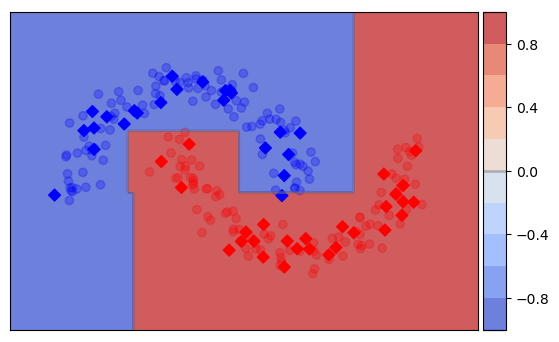

In [20]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

 
#### 1. Why is the decision tree model a good fit for this dataset? 

The decision tree model is a good fit for this dataset because it can capture the spiral shape and complex decision boundary better than a simpler, linear model like logistic regression. Decision trees don’t assume linearity; instead, they split the data along axis-aligned boundaries, which helps them represent non-linear patterns in the data more accurately. This is why we see almost no data points from one class in the opposite colored area. 

 
 

#### 2. Why does the decision boundary of the decision tree look like a Heaviside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data? 

 

This is because of how the tree splits the data space. A Heaviside function is a step-like function that has no smooth transitions. Similarly, a decision tree boundary looks like it’s made up of blocks that are aligned to the axes, so it’s not smooth and continuous. 

 

This structure can lead to **overfitting**, when it tries to capture every detail of the training data, it creates many small, tightly wrapped regions, especially in areas with fewer points. This results in "overfitted" boundaries that follow noise and minor variations instead of general patterns.This is also evidenced by the performance metrics where the model performs perfect on the training data while the accuracy and precision go down on the testing data.
In the plot, the data points cover relatively small proportions of the areas with enough empty space with no datapoints. 

 

#### 3. How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns? 

 

The way decision trees and logistic regression create decision boundaries is pretty different: 

 

- Decision trees produce **step-like, axis-aligned boundaries** that adapt to the shape of the data. This allows them to fit complex, non-linear shapes by creating multiple splits. In this dataset, the tree’s boundaries can follow the twists of the spiral shape, creating boxy, stepwise sections that fit each class. Whereas logistic regression, on the other hand, produces a **linear decision boundary**, which is just a straight line in the feature space. It’s limited to this linear structure, so it’s not able to capture complex, curved shapes. On a dataset like this, with spirals, logistic regression would try to separate the data with one straight line, likely resulting in a lot of misclassified points since it oversimplifies the pattern. 

 

 
 

#### 4. What are the strengths and weaknesses of decision trees compared to logistic regression? 

 

- **Strengths of Decision Trees**: 

    - **Good for non-linear data**: Decision trees can handle complex, non-linear boundaries. 

    - **Easy to interpret**: Each split in the tree represents a straightforward rule, so it’s easier to understand why the model makes certain decisions. 

 

- **Weaknesses of Decision Trees**: 

    - **Prone to overfitting**: Trees tend to create highly specific boundaries that fit the training data too closely, this makes them sensitive to noise and outliers. 

    - **Sensitive to small changes in the data**: Small changes in the training data (like removing a few points) can lead to different splits and, consequently, a different decision boundary, which can make trees unstable. 

    - **Poor linear performance**: Decision trees do not perform as well on datasets that are linear separable, where simpler, linear models like logistic regression are often the better choice


 

- **Strengths of Logistic Regression**: 

    - **Stable with small changes**: Logistic regression isn’t very sensitive to small changes in the data, so its boundary is generally stable. 

    - **Probability estimates**: Logistic regression provides probabilities for each class, which can help interpret how confident the model is in its predictions. 

 

- **Weaknesses of Logistic Regression**: 

    - **Limited to linear boundaries**: Logistic regression can only create straight-line boundaries, so it struggles with complex shapes like the spiral structure in this dataset. 

    - **Oversimplifies complex structures**: For data with non-linear patterns, logistic regression’s linear boundary often fails to capture the full structure, leading to misclassification. 

<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [21]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Training metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Testing metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1-Score: {train_f1}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1-Score: {test_f1}")

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1-Score: 1.0
Testing Accuracy: 1.0
Testing Precision: 1.0
Testing Recall: 1.0
Testing F1-Score: 1.0


In [22]:
# LEAVE BLANK

In [23]:
# LEAVE BLANK

In [24]:
# LEAVE BLANK

In [25]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

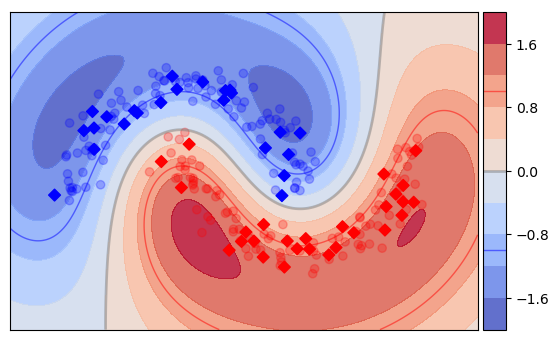

In [26]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

1. Why is the SVM a good fit for this dataset? 

 

SVM with an RBF kernel works really well here because it can handle the curved, non-linear patterns in the data. This dataset has a “moons” shape where a simple, straight line wouldn’t be able to separate the classes well. The RBF kernel lets the SVM create a flexible, curved boundary, which fits the shape of the data nicely and helps it perform accurately. 

 

2. How do support vectors determine the decision boundary, and what impact does this have on the model’s effectiveness? 

 

Support vectors are the “most important” data points in SVM. They’re the points closest to the decision boundary, and they’re the only points that directly influence where the boundary is drawn. By focusing on these specific points, the SVM finds a boundary that maximizes the separation between classes, while ignoring other data points that are farther away. This approach helps SVM generalize well because it doesn’t try to fit every single point perfectly, just the ones that matter most. 

 

3. Why does the SVM produce a smooth, continuous decision boundary, unlike the ‘blocky’ boundaries seen in decision trees? 

 

The SVM’s decision boundary is smooth because it isn’t constrained to split along feature axes like decision trees are. The RBF kernel allows it to create a continuous, flowing boundary that fits the natural shape of the data. Instead of making rectangular, step-like splits, the SVM can adapt its boundary to follow the contours of the data, which is why it looks more like a “curve” than a set of blocks. 

 

4. How do the decision boundaries of SVM differ from the linear boundaries of logistic regression? 

 

Logistic regression tries to separate classes with a straight line, so it doesn’t work well with non-linear patterns like those in the “moons” dataset. SVM with an RBF kernel, on the other hand, can form a flexible boundary that curves around the data, allowing it to capture complex relationships that logistic regression just can’t. This makes SVM a better choice for data with non-linear structures. 

 

5. What are the strengths and weaknesses of SVM compared to logistic regression and decision trees? 

 

	•	Strengths: SVM is great for handling complex boundaries and non-linear data. It’s more flexible than logistic regression and generally more resistant to overfitting than decision trees. 

	•	Weaknesses: However, SVMs can be slower, especially with large datasets, since they require more computational power. Logistic regression is faster and simpler, and decision trees can be easier to interpret because they’re more visual. 

 

6. In what scenarios might logistic regression be more suitable, and when would SVM be a better choice? 


Logistic regression is a good option when you have linearly separable data and want a model that’s simple, fast, and easy to interpret. It’s also great for large datasets where speed is essential. SVM, on the other hand, shines when the data has a complex structure and you need a model that can capture non-linear relationships—especially when accuracy is a priority and you’re willing to invest in the extra computation time. 


7. How do support vectors shape the SVM’s decision boundary, and how does this differ from the recursive partitioning method used by decision trees? 


Support vectors help the SVM create a boundary that’s both flexible and robust. The SVM focuses on these critical points to draw a boundary that maximizes the separation between classes. Decision trees, in contrast, split the data based on feature values, which creates more “blocky” boundaries since each split is aligned with an axis. SVM’s boundary is smoother and adapts to the data in a more natural way, while decision trees partition the space into distinct rectangles. 

<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

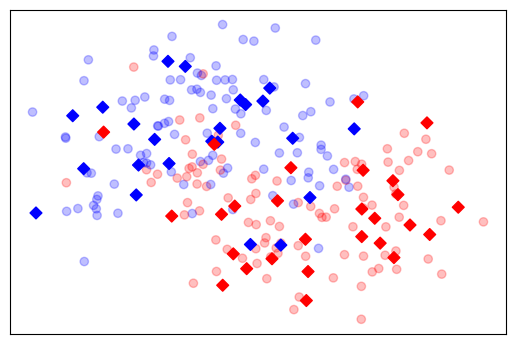

In [27]:
X, y = make_moons(n_samples=250, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test)

*Legend*
| Shape         | Class | Data Type | Color  |
|---------------|-------|-----------|--------|
| Circle        | 0     | Train     | Blue   |
| Diamond       | 0     | Test      | Blue   |
| Circle        | 1     | Train     | Red    |
| Diamond       | 1     | Test      | Red    |


In [28]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

## Exercise 9 - Point 1: How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?

Increased noise in the dataset generally decreases model performance because it makes patterns in the data more difficult to identify accurately. Noise can lead to overfitting, where a model learns the noise as if it were a valid pattern, reducing its generalizability to unseen data.

### Logistic Regression: 
- This model is less likely to overfit compared to more complex models due to its linear nature. However, its performance on highly noisy data can still degrade as it struggles to find a clear linear separation. It may still handle moderate noise better than more complex models because of its simplicity and regularization capabilities.

### Decision Tree: 
- Decision trees are highly sensitive to noise because they try to fit the data as closely as possible by creating complex branches. This can make their decision boundaries very irregular, resulting in overfitting. The more noise present, the more likely a decision tree is to generate non-generalizable rules.

### Support Vector Machine (SVM): 
- SVMs are generally more robust to noise due to their focus on maximizing the margin between classes. However, if noise exists near the decision boundary, SVMs can become sensitive, which may lead to a reduction in margin width and potential overfitting as support vectors may shift.

### Best Model for Handling Noise: 
- Among these, SVMs with an appropriate kernel (e.g., RBF) and regularization are likely to handle noise better due to their margin maximization approach. The hyperparameter tuning in SVMs allows the model to manage the trade-off between maximizing the margin and minimizing classification error.

## Exercise 9 - Point 2: How might the logistic regression model be affected by noisy data?

Logistic regression is generally more resistant to overfitting than non-linear models, but significant noise can shift the decision boundary. This shift leads to reduced performance as the model attempts to find a linear separation influenced by outliers.

The code below illustrates this:

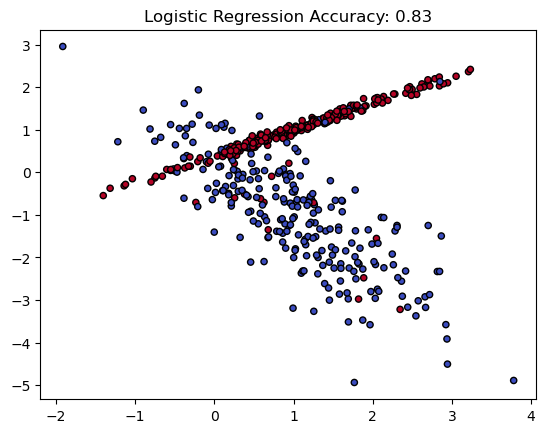

In [19]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generate a synthetic dataset with noise
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, flip_y=0.1, random_state=42)

# Train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

# Plot the decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.title(f"Logistic Regression Accuracy: {accuracy_score(y, y_pred):.2f}")
plt.show()

Conclusion: This code shows how logistic regression handles noise. The decision boundary might shift in the presence of noisy data points, resulting in misclassifications. The plot can illustrate how well the linear boundary fits the data, with potential accuracy decline due to noise-induced boundary shifts.

## Exercise 9 - Point 3:  How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?

Decision trees are more prone to overfitting when faced with noise, as they attempt to split the data perfectly, capturing noise as part of their structure. This leads to a step-like, irregular boundary, which performs well on training data but poorly on unseen data.

## Exercise 9 - Point 4: How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?

SVMs use support vectors to establish the decision boundary. If noise exists near the boundary, these noisy points can become support vectors, leading to a tighter, narrower margin that overfits the data. This sensitivity may compromise the SVM's robustness.

The code below illustrates this:

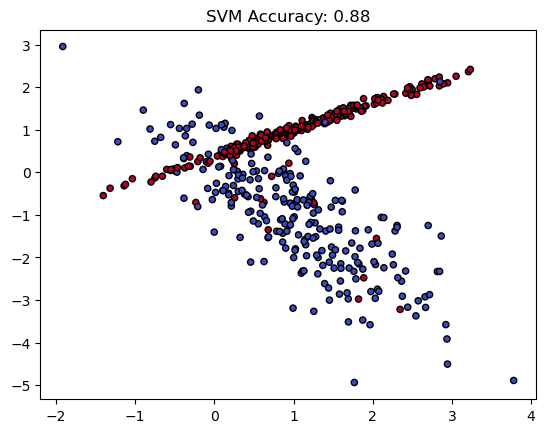

In [47]:
from sklearn.svm import SVC

# Train SVM on the noisy data
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X, y)
y_pred_svm = svm_model.predict(X)

# Plot SVM decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.title(f"SVM Accuracy: {accuracy_score(y, y_pred_svm):.2f}")
plt.show()

Conclusion: This example shows how SVM's decision boundary adapts to data with noise. If the noise is close to the margin, the SVM may create an overfitted boundary to accommodate these points, which reduces generalizability. The visualization demonstrates how the model responds to noisy data.

## Exercise 9 - Point 5: What strategies can be used to mitigate the effects of noise on these models?

### Logistic Regression:

Regularization (L1 or L2): Helps by penalizing large coefficients, making the model less likely to overfit.
Feature Scaling: Ensures uniform contribution from all features, which reduces the impact of noisy outliers.

### Decision Trees:

Pruning: Reduces overfitting by limiting tree depth or removing minimally valuable branches.
Random Forest: Averages multiple trees to reduce sensitivity to noise and improve robustness.

### Support Vector Machines:

Regularization (C parameter): Adjusts the balance between maximizing the margin and minimizing classification error, reducing the influence of noisy data.
Kernel Choice: Proper kernel selection (e.g., RBF) can create smoother boundaries that are less impacted by noise.
Outlier Detection: Pre-processing methods like isolation forests help identify and handle outliers, improving noise robustness.

In conclusion, while all models are affected by noise, employing regularization, ensemble methods, and data pre-processing can mitigate its impact. SVMs, with fine-tuned hyperparameters and careful support vector selection, are often more robust to noise compared to other models.

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [29]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Define the function to get metrics
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision_class_0 = precision_score(y, y_pred, pos_label=0)
    precision_class_1 = precision_score(y, y_pred, pos_label=1)
    recall_class_0 = recall_score(y, y_pred, pos_label=0)
    recall_class_1 = recall_score(y, y_pred, pos_label=1)
    f1_class_0 = f1_score(y, y_pred, pos_label=0)
    f1_class_1 = f1_score(y, y_pred, pos_label=1)
    
    return {
        'accuracy': accuracy,
        'precision_class_0': precision_class_0,
        'precision_class_1': precision_class_1,
        'recall_class_0': recall_class_0,
        'recall_class_1': recall_class_1,
        'f1_class_0': f1_class_0,
        'f1_class_1': f1_class_1
    }


# Train three SVM models with different gamma values
svm_models = {}
gamma_values = [0.01, 'scale', 100]

for gamma in gamma_values:
    model = SVC(kernel='rbf',gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    svm_models[gamma] = model

# Create lists to store metrics data
train_data = []
test_data = []

# Calculate metrics for each model and append to the lists
for gamma, model in svm_models.items():
    train_metrics_dict = get_metrics(model, X_train, y_train)
    train_metrics_dict['gamma'] = gamma
    train_data.append(train_metrics_dict)

    test_metrics_dict = get_metrics(model, X_test, y_test)
    test_metrics_dict['gamma'] = gamma
    test_data.append(test_metrics_dict)

# Create DataFrames for train and test metrics
train_metrics = pd.DataFrame(train_data)
test_metrics = pd.DataFrame(test_data)


# Find the model with the highest accuracy on the test set
best_svm_idx = test_metrics['accuracy'].idxmax()
best_svm = svm_models[test_metrics.loc[best_svm_idx, 'gamma']]

# Display the train and test metrics DataFrames
print("Train Metrics:\n", train_metrics)
print("Test Metrics:\n", test_metrics)

best_model = test_metrics.loc[test_metrics['accuracy'].idxmax()]

best_gamma = best_model['gamma']
best_svm = svm_models[best_gamma]


print("\nBest SVM model based on accuracy(gamma):", best_gamma)
print("SVM model:")
print(best_model)

Train Metrics:
    accuracy  precision_class_0  precision_class_1  recall_class_0  \
0     0.775           0.766355           0.784946        0.803922   
1     0.855           0.868687           0.841584        0.843137   
2     0.975           0.961905           0.989474        0.990196   

   recall_class_1  f1_class_0  f1_class_1  gamma  
0        0.744898    0.784689    0.764398   0.01  
1        0.867347    0.855721    0.854271  scale  
2        0.959184    0.975845    0.974093    100  
Test Metrics:
    accuracy  precision_class_0  precision_class_1  recall_class_0  \
0      0.84           0.857143           0.827586        0.782609   
1      0.86           0.833333           0.884615        0.869565   
2      0.70           0.681818           0.714286        0.652174   

   recall_class_1  f1_class_0  f1_class_1  gamma  
0        0.888889    0.818182    0.857143   0.01  
1        0.851852    0.851064    0.867925  scale  
2        0.740741    0.666667    0.727273    100  

Best S

In [30]:
# LEAVE BLANK

In [31]:
# LEAVE BLANK

In [32]:
# LEAVE BLANK

In [33]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

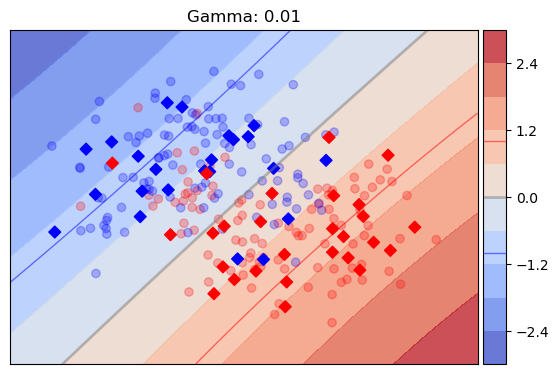

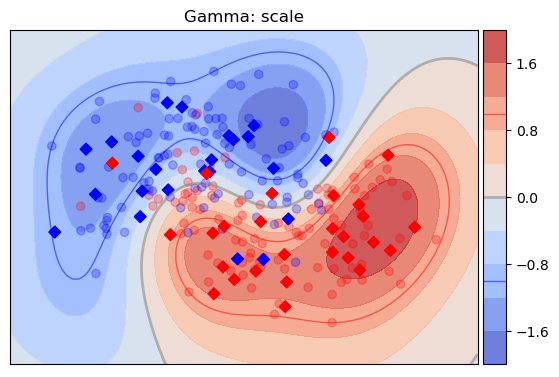

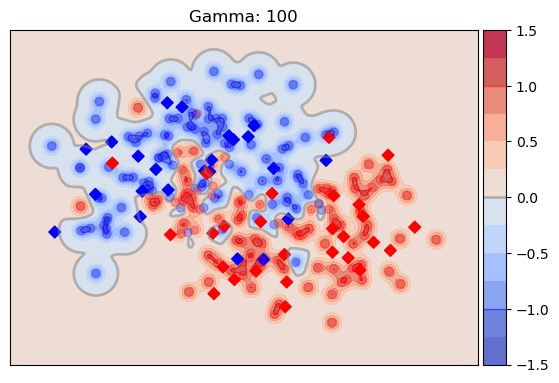

In [34]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [35]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')


1. How does adjusting the gamma parameter impact the model’s complexity? Which values of gamma produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise? 

- Gamma influence: 

    The gamma parameter in SVM defines the range of influence of a single training example and therefore affects the curvature of the decision boundary. A higher gamma value leads to a narrower decision range around the support vectors and makes the model more sensitive to individual data points. 

- Model complexity and gamma: 

    -  Low gamma (gamma: 0.01): Results in a smoother, more generalized decision boundary that may be too simple for complex data sets. This setting tends to lead to underfitting, which is reflected in generally lower performance metrics for accuracy, precision, recall and F1 scores. 

    - High gamma (gamma: 100): Creates a highly sensitive decision boundary that outlines the data points very precisely. The model complexity increases with increasing gamma. While perfect results can be achieved during training, generalization often does not succeed well, as evidenced by a significant drop in test performance metrics, indicating overfitting. 

    - Moderate Gamma (Gamma: Scale): Tends to find a balance between complexity and generalization, capturing the essential patterns of the data set without over-adhering to noise or specific data anomalies, and provides very good accuracy, precision and recall results. 

 

2. Can you pinpoint regions where overfitting or underfitting occurs based on the different gamma values? 

- Overfitting: Most noticeable at Gamma: 100, where the training metrics are almost perfect, but the test metrics are significantly lower, indicating that the model overfits to the training data. The mismatch between training and test performance increases with increasing noise in the data set.   

- Underfitting: Observed at Gamma: 0.01, where the decision boundary of the model is too wide and does not capture the more subtle structure of the data, resulting in suboptimal performance metrics. 

 

3. How do precision and recall vary as you change the gamma parameter? Does a higher gamma lead to better precision at the expense of recall, or the opposite? 

- As the gamma parameter increases, precision and recall improve simultaneously when measuring performance on the training data, without one increasing at the expense of the other. This shows that higher gamma values effectively improve the accuracy and sensitivity of the model in the training dataset. However, it should be noted that this balanced improvement in the training phase is not transferable to the test phase. In the test scenarios, both accuracy and recognition decrease rapidly with increasing gamma, again indicating an overfitting problem. It is therefore not obvious that accuracy increases at the expense of recognition or vice versa. Rather, both metrics are negatively affected by high gamma values when evaluated with the test dataset. 

 

4. How do the test set metrics compare to the training set metrics for different gamma values?  

- The metrics show that the training metrics improve with increasing gamma, while the test metrics peak at gamma = scale and no longer improve at gamma = 100. At gamma = scale, the performance between training and testing is close, suggesting better generalization skills. This shows how important it is to choose a gamma value that avoids overfitting and at the same time appropriately captures the underlying data distribution. 

 

5. Based on these observations, which model would you select, and why? 

- Model Choice: Based on the provided metrics, Gamma = scale would be the best choice. It seems to strike a reasonable balance between fitting the data and maintaining enough generalization to achieve reasonable performance on unseen data. It neither over-fits as it does at high gamma settings nor under-fits as it does at low gamma settings. 

 

6. What modifications could be made to improve the chosen model's performance on the noisy dataset? 

- Parameter tuning: Adjusting gamma around the scale value can further improve model performance. 

- Feature engineering and data cleaning: Implementing more sophisticated feature selection or data preprocessing can help the model to better distinguish between noise and informative features. 

- Cross-validation: Thorough cross-validation ensures the robustness and consistency of the model across different data subsets.

<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [36]:
X, y = make_moons(n_samples=2500, noise=0.4, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the SVM model with gamma=100 to the larger dataset
non_regularized_svm = SVC(kernel='rbf', gamma=100, random_state=42)
non_regularized_svm.fit(X_train, y_train)

# Compute the metrics using the get_metrics function
new_train_metrics = get_metrics(non_regularized_svm, X_train, y_train)
new_test_metrics = get_metrics(non_regularized_svm, X_test, y_test)

# Append the new metrics to train_metrics and test_metrics dataframes
new_train_metrics['gamma'] = 100
new_test_metrics['gamma'] = 100
new_train_metrics['dataset_size'] = 2500
new_test_metrics['dataset_size'] = 2500

# Convert new metrics to DataFrame and concatenate
new_train_metrics_df = pd.DataFrame([new_train_metrics])
new_test_metrics_df = pd.DataFrame([new_test_metrics])

train_metrics = pd.concat([train_metrics, new_train_metrics_df], ignore_index=True)
test_metrics = pd.concat([test_metrics, new_test_metrics_df], ignore_index=True)

# Update previous models' metrics with dataset size
train_metrics['dataset_size'] = train_metrics['dataset_size'].fillna(250)
test_metrics['dataset_size'] = test_metrics['dataset_size'].fillna(250)

print("Updated Train Metrics:\n", train_metrics)
print("\nUpdated Test Metrics:\n", test_metrics)

Updated Train Metrics:
    accuracy  precision_class_0  precision_class_1  recall_class_0  \
0     0.775           0.766355           0.784946        0.803922   
1     0.855           0.868687           0.841584        0.843137   
2     0.975           0.961905           0.989474        0.990196   
3     0.886           0.880881           0.891109        0.889788   

   recall_class_1  f1_class_0  f1_class_1  gamma  dataset_size  
0        0.744898    0.784689    0.764398   0.01         250.0  
1        0.867347    0.855721    0.854271  scale         250.0  
2        0.959184    0.975845    0.974093    100         250.0  
3        0.882295    0.885312    0.886680    100        2500.0  

Updated Test Metrics:
    accuracy  precision_class_0  precision_class_1  recall_class_0  \
0     0.840           0.857143           0.827586        0.782609   
1     0.860           0.833333           0.884615        0.869565   
2     0.700           0.681818           0.714286        0.652174   
3    

In [37]:
# LEAVE BLANK

In [38]:
# LEAVE BLANK


In [39]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


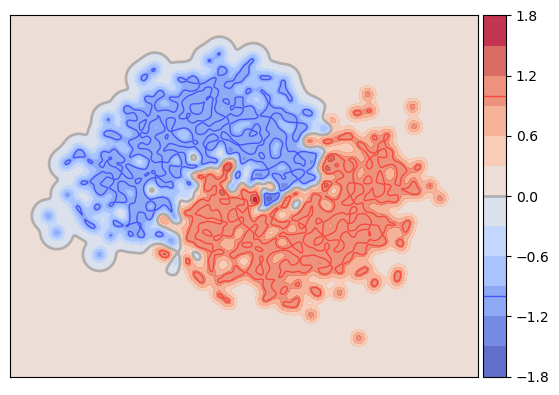

In [40]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [41]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

#### 1. How Does Increasing the Dataset Size Help Reduce Overfitting and Improve Test Performance?
- Increasing the dataset size generally **reduces overfitting** because it provides the model with a broader range of data points, covering various aspects of the data distribution. When the model is trained on a larger dataset, it learns to generalize better instead of memorizing noise or idiosyncrasies from a smaller sample.
- Overfitting often occurs when a model has **too much capacity** relative to the available data—adding more data helps balance this capacity, allowing the model to learn more general features and reducing its sensitivity to individual noisy points.
-  In the test and training metric graphs, we can see that as the dataset size increases, the test performance metrics (accuracy, precision, recall) approach those of the training set. As a result, the metrics on the test set improve and start to align with the training metrics, which is a clear sign of reduced overfitting.
 

#### 2. As More Data Is Added, How Does the SVM's Decision Boundary Become Smoother, Allowing the Model to Generalize Better?
- The **SVM decision boundary** becomes smoother as more data is added, especially for high-gamma values, because the SVM has more data points available to properly determine the boundary. 
- The non-regularized SVM model with a high gamma value creates a very **detailed and complex decision surface** when trained on a smaller dataset, which suggests overfitting. With a larger dataset, the boundary becomes less erratic, as the model learns from a greater volume of data that dampens the influence of individual noisy points. This effect leads to a **wider margin** that is more reflective of the true underlying pattern rather than overreacting to a few outliers.
-  Looking at the test metrics graph, the consistency across precision, recall, and F1 scores indicates that the model is achieving a smoother, more general decision boundary with more data.

#### 3. How Do the Test Metrics (Accuracy, Precision, Recall) Improve in Relation to Training Metrics as the Dataset Size Grows?
-  As the dataset grows, the gap between training and test metrics typically decreases. This happens because a larger dataset better represents the data distribution, reducing overfitting and making the test performance closer to the training performance. Improvements in test metrics reflect the model’s enhanced generalization, meaning its performance on unseen data is more consistent with its performance on the training data.
-  In the graphs, we can see that when the dataset size is smaller, there's a larger gap between training and test metrics, especially in precision and recall. As the dataset size increases, the test metrics get closer to the training metrics, which is a good sign that the model is learning general patterns rather than overfitting to the training data.

#### 4. Is There a Point Where Adding More Data Stops Providing Significant Improvements?
-  This is based on a mathematical perspective which involves **convergence rates**. As sample size increases, the test error converges to the true error of the model.
- Yes, there is a point where adding more data yields **diminishing returns** in performance. Initially, adding data to a limited dataset yields significant improvements, but after a certain threshold, the model reaches a point where additional data doesn’t significantly improve its generalization ability.
- This threshold depends on the model and the dataset characteristics. For the SVM model, particularly with a high gamma value, once the decision boundary has enough support from diverse data points, additional data will have **minimal impact** on model improvement beyond smoothing out fluctuations in performance metrics.


#### 5. Why Does Increasing the Dataset Size Help Counterbalance the High Gamma Value, Thereby Reducing Overfitting?
- A **high gamma value** in an SVM leads to a highly flexible model that tries to fit the training data very precisely, which can result in overfitting. Increasing the dataset size provides more training examples, which forces the decision boundary to **account for a greater diversity** of points, reducing the impact of any individual outlier.
- The high gamma model fits to smaller variations in the dataset; adding more data helps ensure that the variations it tries to fit are less likely to be caused by random noise, thus reducing overfitting and making the model more **robust**.

#### 6. How Does the Increase in Data Help the Model Create a Smoother Decision Boundary?
- In both graphs, the stabilization of the metrics (especially precision and recall) as dataset size increases reflects the SVM's ability to create a smoother boundary. A smoother boundary generalizes better, as shown by the closer alignment of training and test metrics for larger datasets. The model becomes less influenced by noise, leading to more stable and reliable metric values across both graphs.More data allows the SVM to average out small variations and noise in the data, creating a smoother decision boundary.


#### 7. Would You Still Consider Lowering the Gamma Value, or Is Increasing the Dataset Size Sufficient to Address Overfitting?
- While more data can reduce overfitting caused by a high gamma, the graphs suggest that the current gamma might still be a bit too high for the smaller datasets, as the test metrics initially lag behind the training metrics.
- If increasing the dataset size is feasible, it can be a good strategy to reduce overfitting without changing gamma. However, if more data is not available, lowering gamma is another option to create a simpler, more general boundary. Both approaches can help with overfitting, but adjusting gamma may be necessary if expanding the dataset isn’t possible. 

#### 8. In Which Situations Might Increasing the Dataset Size Alone Not Be Enough to Mitigate Overfitting, and How Could Adjusting the Gamma Parameter Help?
- **Increasing dataset size alone may not suffice** when the model is highly sensitive to noise, such as when using an overly complex kernel (e.g., high gamma). In such cases, even with a larger dataset, the model may still overfit because it tries to fit every small fluctuation.
- Adjusting the **gamma parameter** helps in these situations by **reducing model complexity** and ensuring the model does not create excessively narrow boundaries that react to every point. Lowering gamma makes the decision boundary more flexible, allowing it to be smoother even when trained on a larger dataset.

#### 9. After Evaluating the Effect of Dataset Size on Overfitting, Which Model Would You Choose? Do You Believe Increasing the Dataset Size Sufficiently Improves the Performance of the High-Gamma Model, or Would a Lower-Gamma Model Perform Better for This Dataset?
- Given the visualizations, the **high-gamma model** appears to produce a more detailed decision boundary that fits the data very closely but risks overfitting, particularly in complex or noisy regions. Increasing the dataset size has certainly **smoothed out the decision boundary**, indicating better generalization.
- However, a **lower-gamma model** might still be preferable, as it would provide a **wider margin** and be less sensitive to noise and outliers. It offers an inherent reduction in model complexity, thus providing more consistent generalization with less risk of overfitting, regardless of the dataset size.
- The combination of **increased dataset size and reduced gamma** would likely yield the most **robust model**, balancing complexity and generalization effectively.

